In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import mean_squared_error
import random
from numpy import savetxt
from google.colab import files

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from google.colab import drive
import time
from datetime import datetime,timedelta, date
import math
import os

from scipy.ndimage.interpolation import shift

from sympy.solvers import solve
from sympy import Symbol
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#**Data preparation**

In [ ]:
option_data = pd.read_csv('/content/drive/MyDrive/data aqf/oex option data 2000-2020.csv')
underlying_data=pd.read_csv('/content/drive/MyDrive/data aqf/oex underlying.csv')
interest_rate_data=pd.read_csv('/content/drive/MyDrive/data aqf/yield curve.csv')
option_data_european = pd.read_csv('/content/drive/MyDrive/data aqf/xeo option data 2002-2020.csv')
underlying_data[['date']] = pd.to_datetime(underlying_data['date'],format='%Y%m%d')
underlying_data['date'] = underlying_data["date"].dt.date
interest_rate_data[['date']] = pd.to_datetime(interest_rate_data['date'],format='%Y%m%d')
interest_rate_data['date'] = interest_rate_data["date"].dt.date

In [ ]:
def process_data(option_data,underlying_data,interest_rate_data,is_American):
  #Remove options with the wrong date
  min_date=20030101
  max_date=20121231
  option_data=option_data[(option_data['date'] >= min_date) & (option_data['date'] <= max_date)]

  #Remove options below a certain volume
  min_volume=1
  option_data=option_data[option_data['volume'] >= min_volume]

  #Remove call options
  option_data=option_data[ option_data['cp_flag'] == "P" ]

  #Create a time to maturity column (in trading days)
  option_data[['date']] = pd.to_datetime(option_data['date'],format='%Y%m%d')
  option_data['date'] = option_data["date"].dt.date
  option_data[['exdate']] = pd.to_datetime(option_data['exdate'],format='%Y%m%d')
  option_data['exdate'] = option_data["exdate"].dt.date
  if(is_American):
    option_data[['last_date']] = pd.to_datetime(option_data['last_date'],format='%Y%m%d')
    option_data['last_date'] = option_data["last_date"].dt.date
  option_data['maturity']=np.busday_count(option_data['date'],option_data['exdate'], weekmask='1111111') #Do we have to include weekends?

  #Remove options that do not have correct maturity
  min_maturity=7
  max_maturity=90
  option_data = option_data[(option_data['maturity'] <= max_maturity) & (option_data['maturity'] >= min_maturity)]

  #Create a column with market prices
  option_data['market price'] = (option_data['best_bid'] + option_data['best_offer'])/2

  #Add the underlying to the dataframe
  rows=option_data.shape[0]
  underlying_vec=np.empty(rows, dtype=object)
  date_selector=0
  row_number=0
  for index, row in option_data.iterrows():
    while (underlying_data.at[date_selector,'date']!=row['date']):
      date_selector=date_selector+1
    underlying_vec[row_number]=underlying_data.at[date_selector,'close']
    row_number=row_number+1
  option_data['underlying']=underlying_vec

  #Create columns moneyness and time value
  option_data['moneyness'] = option_data['underlying'] / option_data['strike_price'] * 1000
  option_data['time value'] =  option_data['market price'] - (option_data['strike_price']/1000 - option_data['underlying'])

  #Create column with forward volume
  option_data['1d forward volume'] = option_data.groupby(['optionid'])['volume'].shift(-1)

  #Cleaning based on Ruf and Wang 2020 (https://github.com/weiguanwang/Hedging_Neural_Networks/tree/74d5a7b72626e92395d056ced01cb8e135edcbcc)
  option_data.dropna(subset=['impl_volatility'], how='any', inplace=True)
  option_data = option_data[(option_data['impl_volatility'] < 1) & (option_data['impl_volatility'] > 0.01)] 
  option_data = option_data[option_data['volume'] > 0]
  option_data = option_data[option_data['best_bid'] > 0.05]
  option_data = option_data[(option_data['time value']> 0)]
  option_data = option_data[ (2*option_data['best_bid'] > option_data['best_offer'])]
  option_data = option_data[~option_data['1d forward volume'].isna()]
  if(is_American):
    option_data = option_data[option_data['last_date'] == option_data['date']]

  #Add the interest to the dataframe -> maybe should scale it somehow
  rows=option_data.shape[0]
  interest_rate_vec=np.empty(rows, dtype=object)
  date_selector=0
  row_number=0
  for index, row in option_data.iterrows():
    while (interest_rate_data.at[date_selector,'date']<row['date']): #There are dates where options are traded, but no interest is quoted
      date_selector=date_selector+1
      if date_selector>=216968:
        print(date_selector)
        print(interest_rate_data.at[date_selector,'date'])
        print(row['date'])
    i=0
    while (interest_rate_data.at[date_selector+i,'days']<row['maturity']):
      i=i+1
    left_gap=row['maturity']-interest_rate_data.at[date_selector+i-1,'days']
    right_gap=interest_rate_data.at[date_selector+i,'days']-row['maturity']
    if left_gap<right_gap:
      i=i-1
    interest_rate_vec[row_number]=interest_rate_data.at[date_selector+i,'rate']
    row_number=row_number+1
  option_data['interest_rate']=interest_rate_vec

  option_data['maturity']=option_data['maturity']/250
  option_data['strike_price']=option_data['strike_price']/1000

  #Converting some of the columns from objects back to float values
  option_data = option_data.astype({'moneyness': 'float64'})

  return option_data

In [ ]:
option_data=process_data(option_data,underlying_data,interest_rate_data,True)
option_data_european=process_data(option_data_european,underlying_data,interest_rate_data,False)

In [ ]:
option_data

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,optionid,forward_price,index_flag,issuer,exercise_style,maturity,market price,underlying,moneyness,time value,1d forward volume,interest_rate
215739,109764,2003-01-02,2003-01-18,2003-01-02,P,500.0,41.30,42.80,2,0.323715,20842600,NaN,1,CBOE S&P 100 INDEX,A,0.064,42.050,459.5,0.919000,1.55,4.0,1.37095
215800,109764,2003-01-02,2003-01-18,2003-01-02,P,370.0,0.10,0.15,330,0.456722,20873060,NaN,1,CBOE S&P 100 INDEX,A,0.064,0.125,459.5,1.241892,89.625,155.0,1.37095
215805,109764,2003-01-02,2003-02-22,2003-01-02,P,340.0,0.55,0.85,17,0.428497,20873063,NaN,1,CBOE S&P 100 INDEX,A,0.204,0.700,459.5,1.351471,120.2,49.0,1.39453
215807,109764,2003-01-02,2003-02-22,2003-01-02,P,360.0,1.05,1.45,300,0.399460,20873064,NaN,1,CBOE S&P 100 INDEX,A,0.204,1.250,459.5,1.276389,100.75,54.0,1.39453
215808,109764,2003-01-02,2003-02-22,2003-01-02,P,370.0,1.45,1.85,39,0.384597,21341739,NaN,1,CBOE S&P 100 INDEX,A,0.204,1.650,459.5,1.241892,91.15,15.0,1.39453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264305,109764,2012-12-28,2013-02-16,2012-12-28,P,620.0,11.50,12.30,7,0.198526,83448206,NaN,1,CBOE S&P 100 INDEX,A,0.200,11.900,636.17,1.026081,28.07,37.0,0.274633
1264306,109764,2012-12-28,2013-02-16,2012-12-28,P,640.0,18.90,19.80,2,0.176025,83448207,NaN,1,CBOE S&P 100 INDEX,A,0.200,19.350,636.17,0.994016,15.52,66.0,0.274633
1264307,109764,2012-12-28,2013-02-16,2012-12-28,P,660.0,29.30,31.50,7,0.148371,83448208,NaN,1,CBOE S&P 100 INDEX,A,0.200,30.400,636.17,0.963894,6.57,10.0,0.274633
1264338,109764,2012-12-28,2013-03-16,2012-12-28,P,640.0,23.50,24.40,3,0.175640,83151400,NaN,1,CBOE S&P 100 INDEX,A,0.312,23.950,636.17,0.994016,20.12,1.0,0.288166


#**Market Model: Heston**

In [ ]:
class HestonModel():
    
    def __init__(self,
                 option_data_european,
                 underlying_data):
        
        self.underlying_data=underlying_data
        self.option_data_european=option_data_european
                 
    def calibrate_structural(self):
       
        min_date=20030101
        max_date=20121231
        self.underlying_data=self.underlying_data[(self.underlying_data['numerical_date'] >= min_date) & (self.underlying_data['numerical_date'] <= max_date)]
        
        #Calculate (log) returns
        S=self.underlying_data["close"].to_numpy()
        S_lag=shift(S,1,cval=np.NaN)
        r=np.log(np.divide(S,S_lag))*100
        r=r[1:]

        plt.plot(r, 'b')

        #Fit garch model to find ksi (the conditional kurtosis) (from page 345 in Engle and Lee (chapter 11))
        garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1, dist='t')
        model_fit = garch_model.fit(disp="off")
        nu=model_fit.params.to_numpy()[3]
        ksi=3*(nu-2)/(nu-4)
        
        #Fit garch model to calculate Gamma_0
        garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1)
        model_fit = garch_model.fit(disp="off")
        Gamma_0=model_fit.params.to_numpy()
        omega=Gamma_0[0]
        alpha=Gamma_0[1]
        beta=Gamma_0[2]
        print("for Gamma0: omega: " + str(omega) + "(3*10^-7) alpha: " + str(alpha) + "(0.04) beta: " + str(beta) + "(0.95), numbers in brackets are from AitSahlia")
        
        #Set parameters as in AitSahlia page 195, equation 9, where we discretize time to 5 minutes
        N=len(r)
        discretizations=1
        tau=(1/discretizations)
        kappa_0=Gamma_0[0]/(1-Gamma_0[1]-Gamma_0[2])
        theta_0=(1-Gamma_0[1]-Gamma_0[2])/tau
        eta_0=Gamma_0[1]*np.sqrt((ksi-1)*tau) #Note there is a mistake in equation 9 in AitSahlia
        print("for Theta0: kappa: " + str(kappa_0) + "(0.0044) theta: " + str(theta_0) + "(6.93*10^-5) eta: " + str(eta_0) + "(0.0653), numbers in brackets are from AitSahlia")
        epsilon1=np.random.normal(0,1,[N*discretizations,1])
        epsilon2=np.random.normal(0,1,[N*discretizations,1])           
        r_gen=self.generate_Heston(kappa_0,theta_0,eta_0,N,discretizations,tau,epsilon1,epsilon2)

        plt.plot(r_gen,'r')

        #Fit garch model to calculate Gamma_1 
        garch_model=arch.arch_model(r_gen, mean='Zero', vol='GARCH', p=1, q=1)
        model_fit = garch_model.fit(disp="off")
        Gamma_1=model_fit.params.to_numpy()
        
        #Fit garch model with fixed parameters Gamma_1 
        garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1)
        fixed_fit=garch_model.fix(Gamma_1)
        conVol = fixed_fit.conditional_volatility
        resid = fixed_fit.resid            
        omega=Gamma_1[0]
        alpha=Gamma_1[1]
        beta=Gamma_1[2]
        print("for Gamma1: omega: " + str(omega) + "(4*10^-9) alpha: " + str(alpha) + "(0.45) beta: " + str(beta) + "(0.55), numbers in brackets are from AitSahlia")
        Omega=self.create_matrix(omega,alpha,beta,resid,conVol,r,N)
            
        epsilon1=np.random.normal(0,1,[N*discretizations,1])
        epsilon2=np.random.normal(0,1,[N*discretizations,1])  
     
        #res=scipy.optimize.differential_evolution(self.OptFun,args=(Gamma_1,Omega,omega,alpha,beta,N,discretizations,tau,epsilon1,epsilon2),bounds=((0, None),(0, None),(0, None)))
        #options={'eps':1, 'maxiter':50}
        #Impose the feller condition
        #con = lambda x: 2*x[0]*x[1] - x[2]**2
        #nlc = scipy.optimize.NonlinearConstraint(con, 0, np.inf)  
        res=scipy.optimize.minimize(self.OptFun,x0=[kappa_0,theta_0,eta_0],args=(Gamma_1,Omega,omega,alpha,beta,N,discretizations,tau,epsilon1,epsilon2),bounds=((0, None),(0, 2),(0, 2)))
        #This solution should be the final parameters kappa, theta, eta
        solution=res.x
        kappa=solution[0]
        theta=solution[1]
        eta=solution[2]
        print("Final solution=Theta1: kappa: " + str(kappa) + "(2.65) theta: " + str(theta) + "(0.029) eta: " + str(eta) + "(0.154), numbers in brackets are from AitSahlia")
        return solution
                    
    #Function that generates data that follows the Heston model
    def generate_Heston(self,k_0,theta_0,eta_0,N,discretizations,tau,epsilon1,epsilon2):
        r_gen=np.zeros([N,1])
        v_0=0.187377 #Taken from AitSahlia
        v_gen_dis=np.zeros([N*discretizations,1])
        for t in range(0,N*discretizations):
            if t==0:
                v_gen_dis[t]=k_0*theta_0*tau+(1-k_0*tau)*v_0+eta_0*np.sqrt(tau*v_0)*epsilon2[t]
            else:
                v_gen_dis[t]=k_0*theta_0*tau+(1-k_0*tau)*v_gen_dis[t-1]+eta_0*np.sqrt(tau*v_gen_dis[t-1])*epsilon2[t]
            if v_gen_dis[t]<0:
                v_gen_dis[t]=-v_gen_dis[t]
        r_gen_dis=np.multiply(np.sqrt(v_gen_dis*tau),epsilon1)
        for n in range(0,N):
          r_gen[n]=np.sum(r_gen_dis[n*discretizations:(n+1)*discretizations])
        return r_gen    
    
    #Function that calculates omega matrix, as in AitSahlia page 195 (where entries correspond to derivatives)
    def create_matrix(self,omega,alpha,beta,resid,conVol,r,N):
        for t in range(1,N):
            entry1=-1/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
            entry2=-(resid[t-1]**2)/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)*(resid[t-1]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
            entry3=-conVol[t-1]/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)*conVol[t-1]/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
            vec=[[entry1],[entry2],[entry3]]
            if t==1:
                sum=np.matmul(vec,np.transpose(vec))
            else:
                sum=sum+np.matmul(vec,np.transpose(vec))
        return scipy.linalg.inv((1/N)*sum)
    
    #Function that calculates the criterium as in AitSahlia page 196, equation 11, using m from equation 10 (where entries correspond to derivatives)
    def OptFun(self,Theta_1,Gamma_1,Omega,omega,alpha,beta,N,discretizations,tau,epsilon1,epsilon2):
        m=np.array([0, 0, 0])
        kappa=Theta_1[0]
        theta=Theta_1[1]
        eta=Theta_1[2]
        r_gen=self.generate_Heston(kappa,theta,eta,N,discretizations,tau,epsilon1,epsilon2)
        garch_model=arch.arch_model(r_gen, mean='Zero', vol='GARCH', p=1, q=1)
        fixed_fit=garch_model.fix(Gamma_1)
        conVol = fixed_fit.conditional_volatility
        resid = fixed_fit.resid

        resid_lag=shift(resid,1,cval=np.NaN)
        resid=resid_lag[1:]
        conVol_lag=shift(conVol,1,cval=np.NaN)
        conVol=conVol_lag[1:]
        r_gen=r_gen[1:]
        
        m[0]=np.sum(-1/(omega+alpha*np.square(resid)+beta*conVol)+np.divide(np.square(r_gen),2*np.square(omega+alpha*np.square(resid)+beta*conVol)))
        m[1]=np.sum(-np.divide(np.square(resid),(omega+alpha*np.square(resid)+beta*conVol))+np.divide(np.multiply(np.square(r_gen),np.square(resid)),2*np.square(omega+alpha*np.square(resid)+beta*conVol)))
        m[2]=np.sum(-np.divide(conVol,(omega+alpha*np.square(resid)+beta*conVol))+np.divide(np.multiply(np.square(r_gen),conVol),2*np.square(omega+alpha*np.square(resid)+beta*conVol)))
        #for t in range(1,N):
        #    m[0]=m[0]-1/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r_gen[t]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
        #    m[1]=m[1]-(resid[t-1]**2)/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r_gen[t]**2)*(resid[t-1]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
        #    m[2]=m[2]-conVol[t-1]/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r_gen[t]**2)*conVol[t-1]/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
        m=m/N
        result=np.matmul(m.T,np.matmul(Omega,m))
        return result
    
    def calibrate_european(self,params):
        k_1=params[0]
        theta_1=params[1]
        eta_1=params[2]
        #Optimize parameters for every trading day
        date_vec=self.option_data_european["date"].to_numpy()
        days=len(set(self.option_data_european["date"].to_numpy()))
        #days=100
        v_vec=np.zeros([days,1])
        rho_vec=np.zeros([days,1])
        day_selector=0
        
        bound=0.999

        for day in range(0,days):
            if day==10:
              print(rho_vec[0:day])
            if (day%100==0):
              print("day: " + str(day) + " of " + str(days-1))
              
            #Set initial parameters
            if day==0:
                date=date_vec[day_selector]
                v0=0.0349
                rho0=-0.487
            else:
                while (date_vec[day_selector]==prev_date):
                    day_selector=day_selector+1
                date=date_vec[day_selector]
                v0=v_vec[day-1]
                rho0=rho_vec[day-1]
                if abs(rho0)==bound:
                  rho0=-0.487
            
            #select the correct options
            day_data = self.option_data_european[(option_data_european['date']==date)]
            #Minimize for these options
            res=scipy.optimize.minimize(self.sum_squared_error,x0=[v0,rho0],args=(day_data,k_1,theta_1,eta_1),bounds=((0, 1),(-1*bound,bound)),options={'maxiter': 20})
            solution=res.x
            v_vec[day]=solution[0]
            rho_vec[day]=solution[1]
            prev_date=date
        
        #This solution should be the final parameters v, rho, lamda     
        v=np.mean(v_vec)
        rho=np.mean(rho_vec)
        print("table information for v: mean: " + str(np.mean(v_vec)) + " median: " + str(np.median(v_vec)) + " sd: " + str(np.std(v_vec)) + " min: " + str(min(v_vec)) + " max: " + str(max(v_vec)))
        print("table information for rho: mean: " + str(np.mean(rho_vec)) + " median: " + str(np.median(rho_vec)) + " sd: " + str(np.std(rho_vec)) + " min: " + str(min(rho_vec)) + " max: " + str(max(rho_vec)))
        print("v: " + str(v) + "(0.03) rho: " + str(rho) + "(-0.49), numbers in brackets are from AitSahlia")
        return np.array([v,rho])
        
    def put_price(self,K,x,v,T,r,kappa,theta,eta,lamda,rho):
        call_price=self.calcFFT(x,K,r,T,v,kappa,theta,eta,lamda,rho)
        #Use put call parity
        return call_price+K*np.exp(-r*T)-x
    
    def calcFFT(self,x,K,r,T,v,kappa,theta,eta,lamda,rho):
        alpha = 4
        N=2**12
        Upperlimit=1000
        etaa=Upperlimit/N
        lambdaFFT=(2*np.pi)/(N*etaa)
        b=N*lambdaFFT/2
        u=np.linspace(0,N-1,N)*etaa
        KGrid = -b+lambdaFFT*np.linspace(0,N-1,N)
        help_vec=np.zeros([N])
        help_vec[0]=1
        #Carr-Madan Equation
        Psi=np.exp(-r*T)*np.divide(self.HestonCF(u-(alpha+1)*complex(0,1),x,r,T,v,kappa,theta,eta,rho,lamda),(alpha**2+alpha-np.multiply(u,u)+complex(0,1)*(2*alpha+1)*u))
        Function=np.multiply(np.exp(complex(0,1)*b*u),np.multiply(Psi,((etaa/3)*(3+np.power(-1,np.linspace(1,N,N))-help_vec))))
        FastFourierPriceGrid=(np.exp(-KGrid*alpha)/np.pi)*np.real(np.fft.fft(Function))
        SpotOnGrid = (np.log(K)+b)/lambdaFFT+1
        return (1-(SpotOnGrid-np.floor(SpotOnGrid)))*FastFourierPriceGrid[int(np.floor(SpotOnGrid))-1]+(SpotOnGrid-np.floor(SpotOnGrid))*FastFourierPriceGrid[int(np.floor(SpotOnGrid))]
    
    def HestonCF(self,Phi,S0,r,T,V0,kappa,theta,sigma,rho,lamda):
        a=kappa*theta
        u=-0.5
        b = kappa+lamda
        d=np.sqrt((rho*sigma*complex(0,1)*Phi-b)**2-sigma**2*(2*u*complex(0,1)*Phi-Phi**2))
        g=(b-rho*sigma*complex(0,1)*Phi-d)/(b-rho*sigma*complex(0,1)*Phi+d)
        D=(b-rho*sigma*complex(0,1)*Phi-d)/(sigma**2*(1-np.exp(-d*T))/(1-g*np.exp(-d*T)))
        C=r*complex(0,1)*Phi*T+(a/(sigma**2))*((b-rho*sigma*complex(0,1)*Phi-d)*T-2*np.log(((1-g*np.exp(-d*T))/(1-g))))            
        return_value=np.exp(C+D*V0+complex(0,1)*Phi*np.log(S0))
        return return_value
    
    #function that defines optimization criterium
    def sum_squared_error(self,params,day_data,kappa,theta,eta):
        #print('calculating SSE')
        v=params[0]
        rho=params[1]
        lamda=0
        SSE=0
        for index, row in day_data.iterrows():
            real_price=row['market price']
            estimated_price=self.put_price(row['strike_price'],row['underlying'],v,row['maturity'],0,kappa,theta,eta,lamda,rho)
            SSE=SSE+(real_price-estimated_price)**2
        if (math.isnan(SSE)):
            SSE=10**20
        return SSE
    
    def calibrate(self):
        print("Calibrating structural parameters")
        Theta1=self.calibrate_structural()
        print("Calibrating on European options")
        Par=self.calibrate_european(Theta1)
        Params=np.array([Theta1[0],Theta1[1],Theta1[2],Par[0],Par[1]])
        print(Params)
        return Params
    
    def L0(self,X):
        return np.exp(-X/2)
    def L1(self,X):
        return np.multiply(np.exp(-X/2),(1-X))
    def L2(self,X):
        return (1/2)*np.multiply(np.exp(-X/2),(np.multiply(X,X)-4*X+2))
    
    def generate_Heston_matrix(self,v_0,rho,kappa,theta,eta,m,N,S_0,h,epsilon):
        S_paths=np.zeros([N,m])
        #Multiply epsilon by h to deal with the timestep
        epsilon=epsilon*np.sqrt(h)
        v_0=v_0*np.ones([1,N])
        for ti in range(0,m):
            if ti==0:
                v=kappa*theta+(1-kappa)*v_0+eta*np.sqrt(v_0)*epsilon[ti,:,1]
                v=abs(v)
                S=np.exp(np.multiply(np.sqrt(v),epsilon[ti,:,0]))*S_0
                S_paths[:,ti]=S
            else:
                v=kappa*theta+(1-kappa)*v+eta*np.sqrt(v)*epsilon[ti,:,1]
                v=abs(v)
                S=np.exp(np.multiply(np.sqrt(v),epsilon[ti,:,0]))*S_0
                S_paths[:,ti]=S
        return S_paths
    
    def price_option_LSM(self,S_0,K,maturity,r,epsilon,params,m,N):
        kappa=params[0]
        theta=params[1]
        eta=params[2]
        v=params[3]
        rho=params[4]
        h=maturity/m
        max_vec=np.vectorize(max,otypes=[np.float64])
        #simulate path
        S_paths=self.generate_Heston_matrix(v,rho,kappa,theta,eta,m,N,S_0,h,epsilon)
       
        #create matrix of cashflows, and matrix of discount rates
        cashflow_matrix=np.zeros([N,m])
        discount_matrix=np.ones([N,m])
        for ti in range(0,m):
            discount_matrix[:,ti]=discount_matrix[:,ti]*np.exp(-r*ti)    
        cashflow_matrix[:,m-1]=max_vec(K-S_paths[:,m-1],0)
    
        #recursively calculate the cashflows
        for ti in range(m-2,-1,-1):
            exercise_value=max_vec(K-S_paths[:,ti],0)
            #calculate continuation value by regressing in the money options
            itm_indices=np.where(exercise_value > 0)[0]
            if (np.shape(itm_indices)[0]>0):
              Y=np.matmul(np.multiply(cashflow_matrix,discount_matrix),np.ones([m,1]))
              X=np.column_stack([np.ones([N,1]),self.L0(S_paths[:,ti]),self.L1(S_paths[:,ti]),self.L2(S_paths[:,ti])])
              Y_itm=Y[itm_indices]
              X_itm=X[itm_indices,:] 
              beta=np.linalg.lstsq(np.matmul(X_itm.T,X_itm),np.matmul(X_itm.T,Y_itm),rcond=1)[0]
              continuation_value=np.matmul(X,beta)
              exercise_indices=np.where((exercise_value>continuation_value[0,:])*1 == 1)[0]
              cashflow_matrix[exercise_indices,:]=np.zeros([len(exercise_indices),m])
              cashflow_matrix[exercise_indices,ti]=exercise_value[exercise_indices]
        #the option price is the mean of the discounted cashflows
        option_value=np.mean(np.matmul(np.multiply(cashflow_matrix,discount_matrix),np.ones([m,1])))
        return option_value
    
    def price_american_options(self,option_data,params,m=50,N=1000):
        rho=params[4]
        epsilon=np.random.multivariate_normal([0,0],[[1,rho],[rho,1]],[m,N])
        i=0
        mape=0
        mse=0
        rows=np.shape(option_data)[0]
        predicted_prices=np.zeros(rows)
        total_time=0
        #rows=1000
        for index, row in option_data.iterrows():          
              #if (i%np.round(rows/10)==0):
              #  print(i)
              if i>rows:
                break
              start_price_time=time.perf_counter() 
              estimated_option_value=self.price_option_LSM(row["underlying"],row["strike_price"],row["maturity"],row["interest_rate"]/250,epsilon,params,m,N)
              predicted_prices[i]=estimated_option_value
              end_price_time=time.perf_counter() 
              total_time=total_time+end_price_time-start_price_time
              true_option_value=row["market price"]
              #print("underlying: "  + str(row["underlying"]) + " strike: " + str(row["strike_price"]) + " maturity: " + str(row["maturity"]))
              #print("estimated: "  + str(estimated_option_value) + " true: " + str(true_option_value))
              mape=mape+(1/rows)*(np.abs(estimated_option_value-true_option_value)/true_option_value)
              mse=mse+(1/rows)*(true_option_value-estimated_option_value)**2
              i=i+1
        #print("MAPE: " + str(mape))
        #print("RMSE: " + str(np.sqrt(mse)))
        #print("total time: " + str(total_time) + ", time per option: " + str(total_time/rows))
        return predicted_prices

In [ ]:
class AdHocBlackScholes():

  def __init__(self,
               training_data):
    impl_vol = self.implied_volatility(training_data)
    X_reg = self.create_regression_data(training_data)
    self.linreg = LinearRegression().fit(X_reg, impl_vol)
    self.max_vec = np.vectorize(max, otypes=[np.float64])     

  def create_regression_data(self,X):
    X_reg = X[['strike_price','maturity']]
    X_reg['KT']=(X_reg['strike_price']*X_reg['maturity'])
    X_reg=X_reg.values
    return X_reg

  def implied_volatility(self,data):
    underlying = data[['underlying']].values.ravel().astype(float)
    strike_price = data[['strike_price']].values.ravel().astype(float)
    maturity = data[['maturity']].values.ravel().astype(float)
    interest_rate = data[['interest_rate']].values.ravel().astype(float)/250
    #interest_rate = interest_rate*0
    value = data[['market price']].values.ravel().astype(float)
    return self.find_vol(value,interest_rate,underlying,maturity,strike_price)

  def calculate_prices(self,vol,data):
    underlying = data[['underlying']].values.ravel().astype(float)
    strike_price = data[['strike_price']].values.ravel().astype(float)
    maturity = data[['maturity']].values.ravel().astype(float)
    interest_rate = data[['interest_rate']].values.ravel().astype(float)/250
    #interest_rate = interest_rate*0
    #return bs_formula_P(interest_rate,vol,underlying,maturity,strike_price)
    return self.max_vec(self.bs_formula_P(interest_rate,vol,underlying,maturity,strike_price),0)

  def find_vol(self,V,r,s,T,K):
      if isinstance(V, float):
          x0=np.ones(1)*0.5
      else:
          x0=np.ones(len(V))*0.5
      tol=10**-5
      f = lambda sigma: self.bs_formula_P(r,sigma,s,T,K)-V
      df = lambda sigma: self.vega(r,sigma,s,T,K)
      return self.newton(f,df,x0,tol)

  def bs_formula_P(self,r,sigma,s,t,K):
      # Value of an European put option
      d1 = np.log(np.divide(s,K)) + np.divide(np.multiply((0.5*np.square(sigma)+r),t),np.multiply(sigma,np.sqrt(t)))
      d2 = d1 - np.multiply(sigma,np.sqrt(t))
      P = np.multiply(-s,norm.cdf(-d1)) + np.multiply(np.multiply(K,np.exp(np.multiply(-r,t))),norm.cdf(-d2))
      return P

  def vega(self,r,sigma,s,t,K):
      d1 = np.log(np.divide(s,K)) + np.divide(np.multiply((0.5*np.square(sigma)+r),t),np.multiply(sigma,np.sqrt(t)))
      return np.multiply(np.multiply(s,norm.pdf(d1)),np.sqrt(t))

  def newton(self,f,df,x0,tol):
      x = x0
      maxit = 100
      it = 0
      ind = np.abs(f(x)/df(x))>tol
      while it < maxit and np.any(ind):
          # Iterate on the indices that haven't yet converged
          ind = np.abs(f(x)/df(x))>tol
          x[ind]=x[ind]-np.divide(f(x),df(x))[ind]
          it=it+1
          # new set of indices to iterate on
      if np.any(ind):
          print('Warning: newton did not converge')
      else:
          print('converged in {it} iterations'.format(it = it))
      return x

  def price_AH_BS(self,data):
    X_reg = self.create_regression_data(data)
    vol_reg = self.linreg.predict(X_reg)
    y_reg = self.calculate_prices(vol_reg,data)
    return y_reg

#**Generative Bayesian Neural Network**

In [ ]:
class GenerativeOptionPricing():

    def __init__(self,
                 data,
                 feature_names,
                 target,
                 market_model,
                 hidden_nodes = [32, 16],
                 learning_rate = 0.001,
                 batch_size = 512,
                 validation = False,
                 split = 0.2,
                 activation_function = 'relu',
                 number_of_outputs = 1,
                 dim_of_input = 2,
                 optimizer = 'Adam',
                 epochs = 100,
                 activation_function_output = 'linear',
                 comp = False,
                 use_linspace = True):
      
        self.data = data
        self.hidden_nodes = hidden_nodes
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.insample_rmse = np.zeros(3)
        self.outsample_rmse = np.zeros(3)
        self.insample_mape = np.zeros(3)
        self.outsample_mape = np.zeros(3)

        #Testing
        self.temp1 = 0
        self.temp2 = 0
        self.temp3 = 0
        self.temp4 = 0

        self.use_linspace = use_linspace
        
        #Checking that the inputs are correctly given
        if feature_names != None and target != None:
            self.feature_names = feature_names
            self.target = target
        else:
            raise ValueError('Please provide the features and the target')

        
        #Initialze the BayesianNeuralNet()
        self.model = DeepNeuralNet(self.learning_rate,
                                   activation_function = activation_function,
                                   list_of_hidden_nodes = self.hidden_nodes,
                                   number_of_outputs = number_of_outputs,
                                   dim_of_input = dim_of_input,
                                   optimizer = optimizer,
                                   activation_function_output = activation_function_output,
                                   comp = comp)

        #Variables needed for caluclating the prediction performance
        self.validation = validation
        self.split = 0.2

        #Market model from which the arbitrage-free ITM and OTM option prices
        #are generated
        #train = self.data[(self.data['date'] >= pd.Timestamp(2003,1,1)) & (self.data['date'] < pd.Timestamp(2006,7,1))]
        self.market_model = market_model

        #Dictionary for saving values from the t-1 model
        self.dict_bnn_models = {}
        self.prior_predictions = 0
        self.n_t = 0

    def prep_input_data(self, data, start, end):
        '''
            Filter the data for the day needed as an input
        '''
        start = pd.Timestamp(start)
        end = pd.Timestamp(end)
        df_intraday = self.data[(self.data['date'] >= start) & (self.data['date'] < end)]
        X_train = df_intraday[self.feature_names]
        y_train = df_intraday[self.target]
        return X_train, y_train

    def custom_loss_function(self, prior_predictions, n_t, lamb):
        '''
            This function implements the objective function E(w) defined in the 
            underlying paper on page 594
        '''
        #prior_pred = tf.convert_to_tensor(prior_predictions, dtype=tf.float32)
        def loss(y_true, y_pred):
            atm_pred = y_pred[0:n_t]
            atm_true = y_true[0:n_t]
            itm_otm_pred = y_pred[n_t:]
            itm_otm_true = y_true[n_t:]
            se = K.sum(K.square(y_true - y_pred))
            #pen = lamb * K.sum(K.square(itm_otm_pred - prior_pred))
            pen = lamb * K.sum(K.square(itm_otm_pred - itm_otm_true))
            return se + pen
        return loss

    def compile_bnn(self, lamb):
        '''
            TODO
        '''
        self.model.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate = self.learning_rate),
            loss = self.custom_loss_function(self.prior_predictions, self.n_t, lamb),
            #loss = keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.RootMeanSquaredError()],
        )


    def train_generative_bnn(self, params, num_epochs, lamb):
        '''
            TODO
        '''
        estimated_prices_all = []
        predicted_prices_all = []
        l = list(self.data['date'].unique())
        atm_data = self.data[(self.data['moneyness'] >= 0.97) & (self.data['moneyness'] < 1.03)]
        itm_data = self.data[(self.data['moneyness'] < 0.97)]
        otm_data = self.data[(self.data['moneyness'] >= 1.03)]
        itm_otm_data = pd.concat([otm_data, itm_data])
        comp = True
        k1, k2, k3, k4, k5, k6 = 0, 0, 0, 0, 0, 0


        #Calculate means and covariances for data generation later
        for i in range(0,3):
          if i==0:
            #Python hates me, so this has to look stupid
            itm_data_period=itm_data[(itm_data['date'] >= date(2003, 1, 1)) & (itm_data['date'] < date(2006, 7, 1))]
            otm_data_period=otm_data[(otm_data['date'] >= date(2003, 1, 1)) & (otm_data['date'] < date(2006, 7, 1))]
            #self.mean_itm_heston = itm_data_period[["underlying","strike_price","maturity"]].mean()
            #self.mean_otm_heston = otm_data_period[["underlying","strike_price","maturity"]].mean()
            self.mean_itm_heston = itm_data_period[["underlying","strike_price"]].mean()
            self.mean_otm_heston = otm_data_period[["underlying","strike_price"]].mean()
            v1_itm=itm_data[["moneyness"]].to_numpy()
            v1_otm=otm_data[["moneyness"]].to_numpy()
            v2_itm=itm_data[["strike_price"]].to_numpy()
            v2_otm=otm_data[["strike_price"]].to_numpy()
            #v3_itm=itm_data[["maturity"]].to_numpy()
            #v3_otm=otm_data[["maturity"]].to_numpy()
            v1_itm = np.multiply(v1_itm,v2_itm)
            v1_otm = np.multiply(v1_otm,v2_otm)
            #cov123_itm=np.reshape([v1_itm,v2_itm,v3_itm],[3,len(v1_itm)])
            #cov123_otm=np.reshape([v1_otm,v2_otm,v3_otm],[3,len(v1_otm)])
            cov123_itm=np.reshape([v1_itm,v2_itm],[2,len(v1_itm)])
            cov123_otm=np.reshape([v1_otm,v2_otm],[2,len(v1_otm)])
            self.cov_itm_heston=np.cov(cov123_itm)
            self.cov_otm_heston=np.cov(cov123_otm)

            #mean_itm0 = itm_data_period[["moneyness","maturity"]].mean()
            #cov_itm0 = itm_data_period[["moneyness","maturity"]].cov()
            #mean_otm0 = otm_data_period[["moneyness","maturity"]].mean()
            #cov_otm0 = otm_data_period[["moneyness","maturity"]].cov()
            mean_itm0 = itm_data_period[["moneyness"]].mean()
            cov_itm0 = itm_data_period[["moneyness"]].cov()
            mean_otm0 = otm_data_period[["moneyness"]].mean()
            cov_otm0 = otm_data_period[["moneyness"]].cov()
          if i==1:
            itm_data_period=itm_data[(itm_data['date'] >= date(2003, 1, 1)) & (itm_data['date'] < date(2009, 7, 1))]
            otm_data_period=otm_data[(otm_data['date'] >= date(2003, 1, 1)) & (otm_data['date'] < date(2009, 7, 1))]
            #mean_itm1 = itm_data_period[["moneyness","maturity"]].mean()
            #cov_itm1 = itm_data_period[["moneyness","maturity"]].cov()
            #mean_otm1 = otm_data_period[["moneyness","maturity"]].mean()
            #cov_otm1 = otm_data_period[["moneyness","maturity"]].cov()
            mean_itm1 = itm_data_period[["moneyness"]].mean()
            cov_itm1 = itm_data_period[["moneyness"]].cov()
            mean_otm1 = otm_data_period[["moneyness"]].mean()
            cov_otm1 = otm_data_period[["moneyness"]].cov()
          if i==2:
            itm_data_period=itm_data[(itm_data['date'] >= date(2003, 1, 1)) & (itm_data['date'] < date(2012, 7, 1))]
            otm_data_period=otm_data[(otm_data['date'] >= date(2003, 1, 1)) & (otm_data['date'] < date(2012, 7, 1))]
            #mean_itm2 = itm_data_period[["moneyness","maturity"]].mean()
            #cov_itm2 = itm_data_period[["moneyness","maturity"]].cov()
            #mean_otm2 = otm_data_period[["moneyness","maturity"]].mean()
            #cov_otm2 = otm_data_period[["moneyness","maturity"]].cov()
            mean_itm2 = itm_data_period[["moneyness"]].mean()
            cov_itm2 = itm_data_period[["moneyness"]].cov()
            mean_otm2 = otm_data_period[["moneyness"]].mean()
            cov_otm2 = otm_data_period[["moneyness"]].cov()
        self.mean_itm=[mean_itm0, mean_itm1, mean_itm2]
        self.mean_otm=[mean_otm0, mean_otm1, mean_otm2]
        self.cov_itm=[cov_itm0, cov_itm1, cov_itm2]
        self.cov_otm=[cov_otm0, cov_otm1, cov_otm2]

        #######START OF FOR LOOP###########
        for i, j in enumerate(l):
            #if j <= date(2006,1,1):
            #    continue

            if i % 10 == 0:
                print('\n')
                print('################################')
                print('PROGRESS IN THE DATA: ' + str(i))
                print('################################')
                print('\n')

            if i == 0:
                #Define end and starting time for the considered training day
                start = pd.Timestamp(l[i])
                end = pd.Timestamp(l[i+1])

                #Filter relevant trading day from actual data
                itm_data_intraday = itm_data[(itm_data['date'] >= start) & (itm_data['date'] < end)]
                otm_data_intraday = otm_data[(otm_data['date'] >= start) & (otm_data['date'] < end)]
                atm_intraday = atm_data[(atm_data['date'] >= start) & (atm_data['date'] < end)]

                #Generate prior samples from data
                #input = pd.concat([itm_data_intraday, otm_data_intraday])
                #prior_samples = self.market_model.price_american_options(input, params)
                #self.prior_predictions = prior_samples
                #self.n_t = len(atm_intraday)

                #Generate prior samples from normal distribution
                data = pd.concat([itm_data_intraday, otm_data_intraday, atm_intraday])
                self.n_t = len(data)
                #nu=2*np.round(self.n_t/4)
                nu = 200
                acceptable_maturities = list(data['maturity'].unique())
                maturity_itm = random.choices(acceptable_maturities, k=int(nu/2))
                maturity_otm = random.choices(acceptable_maturities, k=int(nu/2))
                if self.use_linspace:
                  acceptable_strikes = list(data['strike_price'].unique())
                  strike_itm = random.choices(acceptable_strikes, k=int(nu/2))
                  strike_otm = random.choices(acceptable_strikes, k=int(nu/2))
                #underlying_itm, strike_itm, maturity_itm = np.random.multivariate_normal(self.mean_itm_heston, self.cov_itm_heston, int(nu/2)).T
                #underlying_otm, strike_otm, maturity_otm = np.random.multivariate_normal(self.mean_otm_heston, self.cov_otm_heston, int(nu/2)).T
                else:
                  underlying_itm, strike_itm = np.random.multivariate_normal(self.mean_itm_heston, self.cov_itm_heston, int(nu/2)).T
                  ind=np.divide(underlying_itm,strike_itm)>=0.97
                  while any(ind):
                    underlying_itm[ind], strike_itm[ind] = np.random.multivariate_normal(self.mean_itm_heston, self.cov_itm_heston, sum(ind)).T
                    ind=np.divide(underlying_itm,strike_itm)>=0.97
                  underlying_otm, strike_otm = np.random.multivariate_normal(self.mean_otm_heston, self.cov_otm_heston, int(nu/2)).T
                  ind=np.divide(underlying_otm,strike_otm)<1.03
                  while any(ind):
                    underlying_otm[ind], strike_otm[ind] = np.random.multivariate_normal(self.mean_otm_heston, self.cov_otm_heston, sum(ind)).T
                    ind=np.divide(underlying_otm,strike_otm)<1.03
                data2 = data.copy()
                while len(data2)<=int(nu/2):
                  data2 = pd.concat((data2,data2))
                input_itm = data2.head(int(nu/2)).copy()
                input_itm['strike_price']=strike_itm
                input_itm['maturity']=maturity_itm
                if self.use_linspace:
                  moneyness_itm=np.linspace(0.75,0.97,int(nu/2))
                  underlying_itm=np.multiply(strike_itm,moneyness_itm)
                input_itm['underlying']=underlying_itm
                input_itm['moneyness'] = np.divide(underlying_itm,strike_itm)

                input_otm = data2.head(int(nu/2)).copy()
                input_otm['maturity']=maturity_otm
                input_otm['strike_price']=strike_otm
                if self.use_linspace:
                  moneyness_otm=np.linspace(1.03,1.6,int(nu/2))
                  underlying_otm=np.multiply(strike_otm,moneyness_otm)
                input_otm['underlying']=underlying_otm
                input_otm['moneyness'] = np.divide(underlying_otm,strike_otm)

                prior_samples_itm = self.market_model.price_american_options(input_itm, params)
                prior_samples_otm = self.market_model.price_american_options(input_otm, params)

                #prior_samples_itm = self.market_model.price_AH_BS(input_itm)
                #prior_samples_otm = self.market_model.price_AH_BS(input_otm)

                input_itm['market price'] = prior_samples_itm
                input_otm['market price'] = prior_samples_otm

                #Put generated prices in place of market prices
                #input['market price'] = prior_samples

                #Combine atm, otm and itm prices again
                input = pd.concat([data, input_itm, input_otm])  #####atm_intraday
                #input = pd.concat([atm_intraday, itm_data_intraday, otm_data_intraday])
                self.batch_size = len(input)
            
            else:

                #Calculation of the prediction error
                if j >= date(2006, 7, 1) and k1 == 0:
                    k1 += 1
                    feat, targets = self.get_feat_and_targets(error_type = 'prediction',
                                      period = 'pre-crisis',
                                      prediction = False)
                    predicted_prices_all = np.hstack((predicted_prices_all,np.zeros(len(feat))))                    
                    feat, targets = self.get_feat_and_targets(error_type = 'prediction',
                                                          period = 'pre-crisis',
                                                          prediction = True)
                    predictions = self.model.predict(feat)
                    predicted_prices_all[len(predicted_prices_all)-len(predictions):len(predicted_prices_all)]=predictions.flatten()
                    rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                        error_type = 'prediction',
                                                        period = 'pre-crisis')
                    self.outsample_rmse[0]=rmse
                    self.outsample_mape[0]=mape
                    
                if j >= date(2009, 7, 1) and k2 == 0:
                    k2 += 1
                    feat, targets = self.get_feat_and_targets(error_type = 'prediction',
                                      period = 'crisis',
                                      prediction = False)
                    predicted_prices_all = np.hstack((predicted_prices_all,np.zeros(len(feat))))  
                    feat, targets = self.get_feat_and_targets(error_type = 'prediction',
                                                          period = 'crisis',
                                                          prediction = True)
                    predictions = self.model.predict(feat)
                    predicted_prices_all[len(predicted_prices_all)-len(predictions):len(predicted_prices_all)]=predictions.flatten()
                    rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                        error_type = 'prediction',
                                                        period = 'crisis')
                    self.outsample_rmse[1]=rmse
                    self.outsample_mape[1]=mape

                if j >= date(2012, 7, 1) and k3 == 0:
                    k3 += 1
                    feat, targets = self.get_feat_and_targets(error_type = 'prediction',
                                      period = 'post-crisis',
                                      prediction = False)
                    predicted_prices_all = np.hstack((predicted_prices_all,np.zeros(len(feat))))  
                    feat, targets = self.get_feat_and_targets(error_type = 'prediction',
                                                          period = 'post-crisis',
                                                          prediction = True)
                    predictions = self.model.predict(feat)
                    predicted_prices_all[len(predicted_prices_all)-len(predictions):len(predicted_prices_all)]=predictions.flatten()
                    rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                        error_type = 'prediction',
                                                        period = 'post-crisis')
                    self.outsample_rmse[2]=rmse
                    self.outsample_mape[2]=mape
                
                #Define end and starting time for the considered training day
                if j == l[-1]:
                    start = pd.Timestamp(l[i])
                    end = date(2013,1,1)
                else:
                    start = pd.Timestamp(l[i])
                    end = pd.Timestamp(l[i+1])
                
                #Filter relevant trading day from actual data
                itm_data_intraday = itm_data[(itm_data['date'] >= start) & (itm_data['date'] < end)]
                otm_data_intraday = otm_data[(otm_data['date'] >= start) & (otm_data['date'] < end)]
                atm_intraday = atm_data[(atm_data['date'] >= start) & (atm_data['date'] < end)]

                #Generate prior samples from normal distribution
                data = pd.concat([itm_data_intraday, otm_data_intraday, atm_intraday])
                self.n_t = len(data)
                nu = 50
                #nu=2*np.round(self.n_t/4)
                period=2
                if j<date(2010,1,1):
                  period=1
                if j<date(2007,1,1):
                  period=0
                acceptable_maturities = list(data['maturity'].unique())
                maturity_itm = random.choices(acceptable_maturities, k=int(nu/2))
                maturity_otm = random.choices(acceptable_maturities, k=int(nu/2))
                if self.use_linspace:
                  moneyness_itm=np.linspace(0.75,0.97,int(nu/2))
                  moneyness_otm=np.linspace(1.03,1.6,int(nu/2))
                #moneyness_itm, maturity_itm = np.random.multivariate_normal(self.mean_itm[period], self.cov_itm[period], int(nu/2)).T
                #moneyness_otm, maturity_otm = np.random.multivariate_normal(self.mean_otm[period], self.cov_otm[period], int(nu/2)).T
                else:
                  moneyness_itm = np.random.multivariate_normal(self.mean_itm[period], self.cov_itm[period], int(nu/2))
                  moneyness_itm=moneyness_itm.flatten()
                  ind=moneyness_itm>=0.97
                  while any(ind):
                    #print(ind)
                    moneyness_itm=moneyness_itm.flatten()
                    moneyness_itm[ind]=np.reshape(np.random.multivariate_normal(self.mean_itm[period], self.cov_itm[period], int(sum(ind))),[sum(ind)])
                    ind=moneyness_itm>=0.97
                  moneyness_otm = np.random.multivariate_normal(self.mean_otm[period], self.cov_otm[period], int(nu/2))
                  moneyness_otm=moneyness_otm.flatten()
                  ind=moneyness_otm<1.03
                  while any(ind):
                    moneyness_otm=moneyness_otm.flatten()
                    moneyness_otm[ind]=np.reshape(np.random.multivariate_normal(self.mean_otm[period], self.cov_otm[period], int(sum(ind))),[sum(ind)])
                    ind=moneyness_otm<1.03
                data2 = data.copy()
                while len(data2)<=int(nu/2):
                  data2 = pd.concat((data2,data2))
                input_itm = data2.head(int(nu/2)).copy()
                input_itm['moneyness']=moneyness_itm
                input_itm['maturity']=maturity_itm
                input_otm = data2.head(int(nu/2)).copy()
                input_otm['moneyness']=moneyness_otm
                input_otm['maturity']=maturity_otm
                prior_samples_itm = self.model.predict(input_itm[self.feature_names])
                prior_samples_otm = self.model.predict(input_otm[self.feature_names])

                #Plotting purposes



                ################



                input_itm['market price'] = prior_samples_itm
                input_otm['market price'] = prior_samples_otm
                input = pd.concat([data, input_itm, input_otm])  #####data
                self.batch_size = len(input)
                #self.model.model.load_weights('model.h5')

                #Generate prior samples
                #input = pd.concat([itm_data_intraday, otm_data_intraday])
                #if len(input) != 0:
                    #feat, targets = self.prep_input_data(input_temp, start, end)
                #    feat = input[self.feature_names]
                #    targets = np.array(input[self.target])
                #    prior_samples = self.model.predict(feat)
                #    self.model.model.load_weights('model.h5')
                #    self.prior_predictions = prior_samples
                #    self.n_t = len(atm_intraday)
                #    input['market price'] = prior_samples
            #####END OF FOR LOOP#######

            #Combine atm, otm and itm prices again
            #if len(input) != 0:
            #    input = pd.concat([atm_intraday, input])
            #    batch_size = len(input)
            #else:
            #    input = atm_intraday
            #    batch_size = len(input)

            #Extract features and targets for training
            feat = input[self.feature_names]
            targets = input[self.target]

            ###Train the GBNN
            if comp:
              self.compile_bnn(lamb)
              #self.model.model.save_weights('model.h5')
              comp = False
            if i==0:
              hist = self.model.train(feat, targets, num_epochs*10, self.batch_size)
            else:
              hist = self.model.train(feat, targets, num_epochs, self.batch_size)

            y_pred_train = self.model.predict(feat)
            #plt.figure(figsize=(15,7))
            #plt.plot(feat, targets, 'o', alpha=0.5, label='Data', color = 'green')
            #plt.plot(feat, y_pred_train, 'x', alpha = 0.5, label = 'Predictions', color = 'red')
            #plt.legend(loc='best')
            #plt.show()

            print("For loop run: " + str(i))
            print('Training loss: ' + str(hist.history['loss'][-1]))

            '''
            if i == 0:

                itm_mon = itm_data_intraday['moneyness']
                otm_mon = otm_data_intraday['moneyness']
                atm_mon = atm_intraday['moneyness']

                itm_mat = itm_data_intraday['maturity']
                otm_mat = otm_data_intraday['maturity']
                atm_mat = atm_intraday['maturity']

                itm_pred = itm_data_intraday['market price']
                otm_pred = otm_data_intraday['market price']
                atm_pred = atm_intraday['market price']

                plt.figure(figsize=(15, 7))
                ax = plt.axes(projection='3d')
                ax.scatter(itm_mon, itm_mat, itm_pred, c='red', cmap='viridis', linewidth=0.8, label = 'Heston ITM')
                ax.scatter(atm_mon, atm_mat, atm_pred, c='green', cmap='viridis', linewidth=0.8, label = 'Data ATM')
                ax.scatter(otm_mon, otm_mat, otm_pred, c='purple', cmap='viridis', linewidth=0.8, label = 'Heston OTM')
                plt.legend(loc = 'best')
                plt.show()
            '''
            if i == 0:

                itm_mon = underlying_itm/strike_itm
                otm_mon = underlying_otm/strike_otm
                atm_mon = atm_intraday['moneyness']

                itm_mat = maturity_itm
                otm_mat = maturity_otm
                atm_mat = atm_intraday['maturity']

                itm_pred = prior_samples_itm
                otm_pred = prior_samples_otm
                atm_pred = atm_intraday['market price']

                plt.figure(figsize=(15, 7))
                ax = plt.axes(projection='3d')
                ax.scatter(itm_mon, itm_mat, itm_pred, c='red', cmap='viridis', linewidth=0.8, label = 'Heston ITM')
                ax.scatter(atm_mon, atm_mat, atm_pred, c='green', cmap='viridis', linewidth=0.8, label = 'Data ATM')
                ax.scatter(otm_mon, otm_mat, otm_pred, c='purple', cmap='viridis', linewidth=0.8, label = 'Heston OTM')
                plt.legend(loc = 'best')
                plt.show()

            if i <= 3:
                x = input['moneyness'].values
                y = input['maturity'].values
                z = input['market price'].values

                plt.figure(figsize=(15, 7))
                ax = plt.axes(projection='3d')
                ax.scatter(x, y, z, c='green', cmap='viridis', linewidth=0.5)
                ax.scatter(x, y, y_pred_train, c='red', cmap='viridis', linewidth=0.5)
                plt.show()


            #Calculation of the estimation error
            if j >= date(2006, 12, 31) and k4 == 0:
                k4 += 1
                feat, targets = self.get_feat_and_targets(error_type = 'estimation',
                                                          period = 'pre-crisis',
                                                          prediction = False)
                #predictions = self.cal_average_pred(feat)
                predictions = self.model.predict(feat)
                estimated_prices_all=np.hstack((estimated_prices_all,predictions.flatten()))
                rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                    error_type = 'estimation',
                                                    period = 'pre-crisis')
                self.insample_rmse[0]=rmse
                self.insample_mape[0]=mape


            if j >= date(2009, 12, 31) and k5 == 0:
                k5 += 1
                feat, targets = self.get_feat_and_targets(error_type = 'estimation',
                                                          period = 'crisis',
                                                          prediction = False)
                #predictions = self.cal_average_pred(feat)
                predictions = self.model.predict(feat)
                estimated_prices_all=np.hstack((estimated_prices_all,predictions.flatten()))
                rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                    error_type = 'estimation',
                                                    period = 'crisis')
                self.insample_rmse[1]=rmse
                self.insample_mape[1]=mape
            if j == l[-1]  and k6 == 0:
                k6 += 1
                feat, targets = self.get_feat_and_targets(error_type = 'estimation',
                                                          period = 'post-crisis',
                                                          prediction = False)
                predictions = self.model.predict(feat)
                estimated_prices_all=np.hstack((estimated_prices_all,predictions.flatten()))
                rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                    error_type = 'estimation',
                                                    period = 'post-crisis')
                self.insample_rmse[2]=rmse
                self.insample_mape[2]=mape
        savetxt('gann_estimation.csv', estimated_prices_all, delimiter=',')
        files.download("gann_estimation.csv")
        savetxt('gann_prediction.csv', predicted_prices_all, delimiter=',')
        files.download("gann_prediction.csv")
        return self.insample_rmse, self.insample_mape, self.outsample_rmse, self.outsample_mape

    def cal_rmse_and_mape(self, predictions, targets, error_type = None, period = None):
        '''
            TODO
        '''
        #rmse_prediction = math.sqrt(np.mean((predictions - targets[0:, None])**2))
        rmse_prediction = mean_squared_error(predictions, targets, squared=False)
        mape = np.mean(np.divide(abs(predictions - targets[0:, None]), targets[0:, None]))
        if period == None or error_type == None:
            raise ValueError('A period and error type must be specified')
        else:
            print('\t \t \t \t \t \t \t \t RMSE ' + error_type +  ' error ' + str(period) + ': ' + str(rmse_prediction))
            print('\t \t \t \t \t \t \t \t MAPE ' + error_type + ' error ' + str(period) + ': ' + str(mape))
        return rmse_prediction, mape

    def get_feat_and_targets(self, error_type = None, period = None, prediction = True):
        '''
            TODO
        '''
        if period == None or error_type == None:
            raise ValueError('A period and error type must be specified')
        else:
            print('\t \t \t \t \t \t \t \t Start calculating ' + error_type +  ' error for ' + str(period) + ' period')
            if period == 'pre-crisis':
                if prediction:
                    start = date(2006,7,1)
                else:
                    start = date(2003,1,1)
                end = date(2007,1,1)
            elif period == 'crisis':
                if prediction:
                    start = date(2009,7,1)
                else:
                    start = date(2007,1,1)
                end = date(2010,1,1)
            else:
                if prediction:
                    start = date(2012,7,1)
                else:
                    start = date(2010,1,1)
                end = date(2013,1,1)
        data = self.data[(self.data['date'] >= start) & (self.data['date'] < end)]
        X = data[self.feature_names]
        y = np.array(data[self.target])
        return X, y

In [ ]:
class DeepNeuralNet():
    
    '''
        TODO
    '''
    
    def __init__(self, 
                    learning_rate,
                    activation_function,
                    list_of_hidden_nodes,
                    number_of_outputs,
                    dim_of_input,
                    optimizer,
                    activation_function_output = 'linear',
                    comp = True):
        '''
            TODO continue setting up a rather general DQN framework
        '''
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.optimizer = optimizer
        self.list_of_hidden_nodes = list_of_hidden_nodes
        self.number_of_outputs = number_of_outputs
        
        #Completely define structure of the network 
        self.list_of_hidden_nodes_and_outputs = self.list_of_hidden_nodes + [self.number_of_outputs]
        
        #Define sequential model
        self.model = Sequential()
        
        for j, k in enumerate(self.list_of_hidden_nodes_and_outputs):
            if j == 0:
                self.model.add(Dense(k, activation = self.activation_function, input_dim = dim_of_input,
                               kernel_initializer=initializers.RandomNormal(stddev=1)))
                self.model.add(BatchNormalization())
            elif k == number_of_outputs:
                temp = self.list_of_hidden_nodes_and_outputs[j-1]
                self.model.add(Dense(k, activation = activation_function_output,
                               kernel_initializer=initializers.RandomNormal(stddev=(2/temp)**0.5)))
            else:
                temp = self.list_of_hidden_nodes_and_outputs[j-1]
                self.model.add(Dense(k, activation = self.activation_function,
                               kernel_initializer=initializers.RandomNormal(stddev=(2/temp)**0.5)))
                
        if self.optimizer == 'SGD':
            opt = keras.optimizers.SGD(learning_rate = self.learning_rate)
        elif self.optimizer == 'Adam':
            opt = keras.optimizers.Adam(learning_rate = self.learning_rate)
        else:
            raise ValueError('The optimizer has to be either Adam or SGD')
            
        if comp:    
          self.model.compile(optimizer = opt, loss = keras.losses.MeanSquaredError())
        
        print(self.model.summary())

    def train(self, X_train, y_train, epochs, mini_batch_size):
        '''
            Implementing the training for the Deep Neural Network
        '''
        hist = self.model.fit(X_train, y_train, 
                        batch_size = mini_batch_size,
                        epochs = epochs, verbose = 0)
        return hist
    
        
    def predict(self, X_input):
        '''
            Predicts output for a given input
        '''
        return self.model.predict(X_input)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 9,217
Trainable params: 8,961
Non-trainable params: 256
_________________________________________________________________
None


################################
PROGRESS IN THE DATA: 0
################################


For loop run: 0
Training loss: 13011.00390625


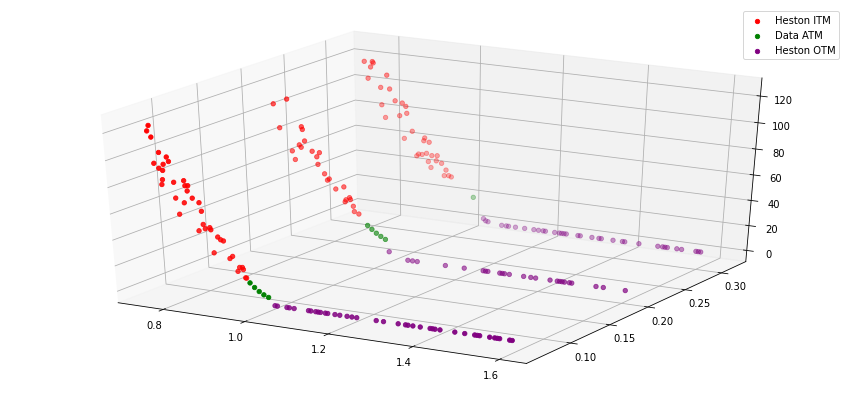

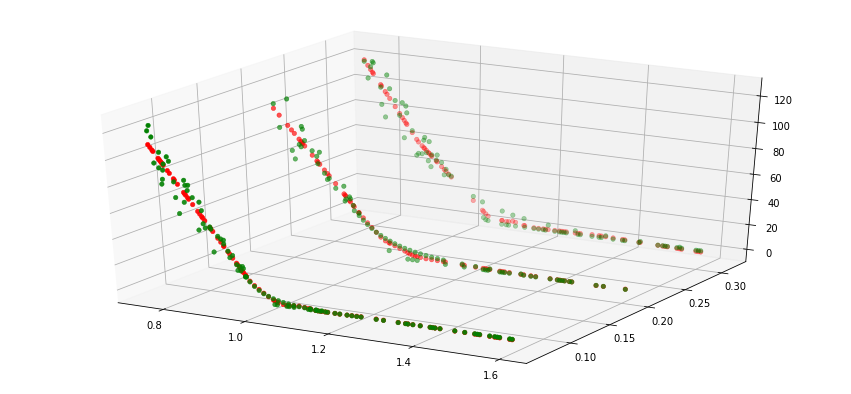

For loop run: 1
Training loss: 148.89218139648438


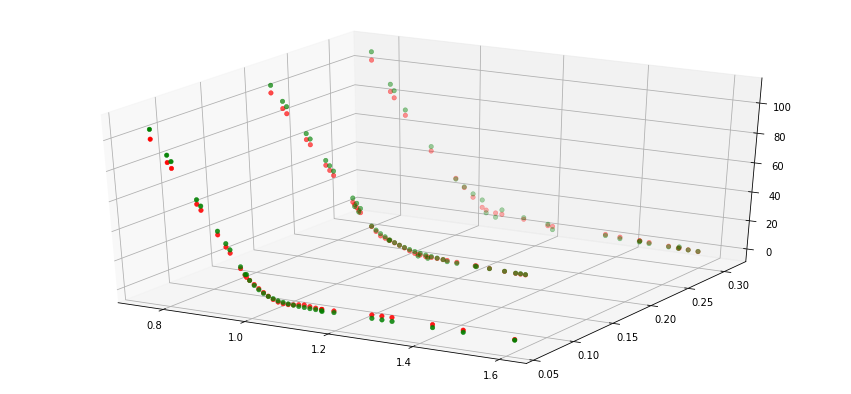

For loop run: 2
Training loss: 247.3921356201172


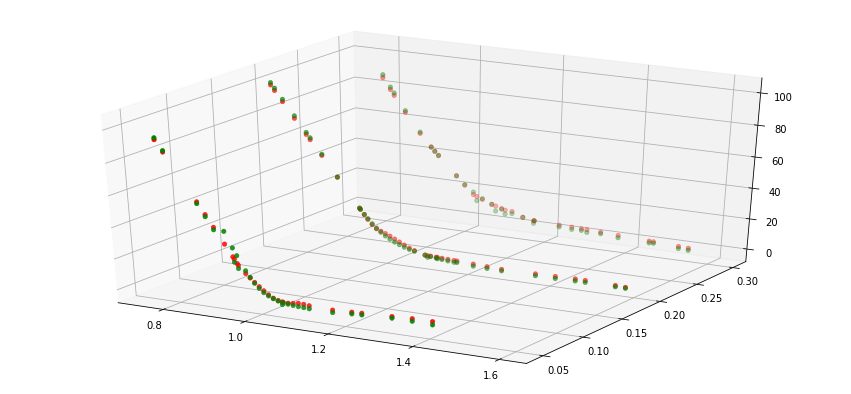

For loop run: 3
Training loss: 77.62274932861328


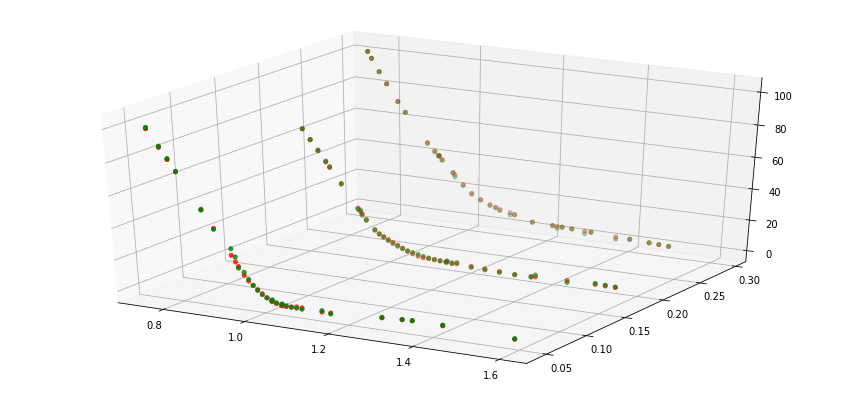

For loop run: 4
Training loss: 31.905935287475586
For loop run: 5
Training loss: 72.93507385253906
For loop run: 6
Training loss: 49.05860900878906
For loop run: 7
Training loss: 32.76197052001953
For loop run: 8
Training loss: 39.782676696777344
For loop run: 9
Training loss: 30.74753189086914


################################
PROGRESS IN THE DATA: 10
################################


For loop run: 10
Training loss: 597.640869140625
For loop run: 11
Training loss: 81.58282470703125
For loop run: 12
Training loss: 72.70995330810547
For loop run: 13
Training loss: 78.6617660522461
For loop run: 14
Training loss: 19.912269592285156
For loop run: 15
Training loss: 100.03553771972656
For loop run: 16
Training loss: 55.43912887573242
For loop run: 17
Training loss: 61.70302200317383
For loop run: 18
Training loss: 20.740278244018555
For loop run: 19
Training loss: 71.76348114013672


################################
PROGRESS IN THE DATA: 20
################################


For loop run:

KeyboardInterrupt: ignored

In [ ]:
#Define Market Model for generating arbitrage-free prices 
market_model = HestonModel(option_data_european, underlying_data)
#train = option_data[(option_data['date'] >= pd.Timestamp(2003,1,1)) & (option_data['date'] < pd.Timestamp(2003,1,3))]
#market_model = AdHocBlackScholes(train)

#Define parameters for the market model (later found via calibration)
params = np.array([ 1.20106692e+00,  8.86737492e-02,  3.21321381e-01,  1.12821414e-03, -2.39050628e-01])
#params = np.array([0.489844, 0.140483, 4.734988, 0.069948, -0.147300])


    
#Create instance of the Generative Option Pricer
GOP = GenerativeOptionPricing(option_data, 
                            ['moneyness','maturity'],
                            'market price',
                            market_model,
                            hidden_nodes = [128,64],
                            learning_rate = 0.001,
                            batch_size = 16)
insample_rmse, insample_mape, outsample_rmse, outsample_mape = GOP.train_generative_bnn(params, 
                          lamb = 0.9, 
                          num_epochs = 100)
